# Sufficiency of fast-TDE sample size

In [7]:
import numpy as np
from math import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

__Deriving sample size of 100__:

Rate of fast-TDEs (Angus et al. 2022): 2x10^-8 events Mpc^-3 yr^-1

Assume for LSST:

- Footprint of 18,000 deg2 for Wide-Fast-Deep Survey (whole sky=41,253 deg2) 

- Baseline of ~3 years. LSST will run for 10 years, but its fields will be observable for ~6 months of the year, and temporal edge gaps will decrease detection efficiency --> effective baseline of 3 years.

- Volume: z~0.2 - 0.35 (corresponding to a comoving volumes of 3.9 - 11.2 Gpc^3). This will encapsulate most fast-TDE candidates within the average depth of a single LSST image (m=24.5), for fast-TDE candidates with peak luminosities of -17.5<M<-19.5 and dynamic light curve range between 1.5-3.6 magnitudes. 

In [24]:
lower_predict_sample=2e-8*(18000/41253)*(3.9*10**9)*3
upper_predict_sample=2e-8*(18000/41253)*(11.2*10**9)*3

print('Number of fast-TDEs to be discovered by LSST: %i - %i events'%(lower_predict_sample,upper_predict_sample))

Number of fast-TDEs to be discovered by LSST: 102 - 293 events


Thus we conservatively expect ~100 fast-TDEs to be found within LSST

**Set sample size**

In [8]:
sample_size=100

**Example test-case:**
    
Simulate 1 set of 100 events drawn from a uniform distribution of galaxies, assign them a M$_{BH}$ value based on one of the predicted scaling relationships (with random scatter), alongside an observational uncertainty

Then test whether the fitted slope to this sample is statisticaly distinguishable from the other predicted scaling relationship

Slope = 3.356 +/- 0.151 Red Chi2 = 1.182889565006511


Text(0, 0.5, 'Log M$_{BH}$')

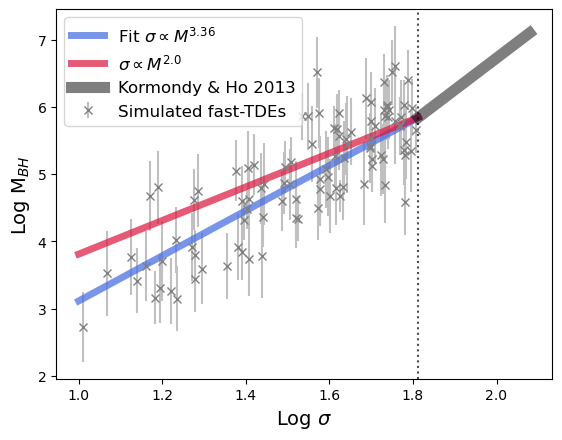

In [17]:
# Assume random sample of 100 galaxy sigma measurements, drawn from uniform distribution
sigmas=np.random.uniform(low=10.0, high=65.0, size=sample_size)
logsigmas=np.log10(sigmas)


#Force the intercept at the turn over at 65km/s corresponds from Kormondy & Ho M_BH-sigma relation for high MBH
intercept=np.log10((1.4*10**8)*((65./200.)**4.72))


# Assign each galaxy a BH-mass based on assumed M-sigma relation at low BH mass (here sigma^3.4 +6.5)
m_bhs=((logsigmas-np.log10(65))*3.4)+intercept


# Assign random uncertainty based on 2020neh M_bh accuracy (+/-0.5 dex)
err_m_bhs=np.random.normal(loc=0.0,scale=0.5,size=sample_size)


# Randomly scatter BH masses by error
m_bhs_obs=m_bhs+err_m_bhs


# Assign measured uncertainty: from MOSFiT (Mockler et al. 2018), systematic = 0.2, statistical = 0.1,
# and include additional random gaussian scatter with mean of 0.1. 
err_obs_m_bhs=np.zeros(100)+0.5+np.random.normal(loc=0.0,scale=0.1,size=sample_size)


# Fit slope to data
def linearFunc(x,slope):
    y = ((x - np.log10(65)) * slope) + intercept
    return y

line_fit,cov=curve_fit(linearFunc,logsigmas,m_bhs_obs,sigma=err_obs_m_bhs)

slope = line_fit[0]
d_slope = np.sqrt(cov[0][0])

y_model = (slope * (logsigmas-np.log10(65)) ) + intercept
chisqr = ((m_bhs_obs-y_model)/err_obs_m_bhs)**2
chisqr_tot = np.sum(chisqr)

sig_x=np.linspace(log10(10.0),log10(65.0))
high_sig=np.linspace(log10(65.0),log10(120.0))

print('Slope = %.3f +/- %.3f'%(slope,d_slope),'Red Chi2 =',chisqr_tot/(len(m_bhs_obs)-2))

plt.errorbar(logsigmas,m_bhs_obs,yerr=err_obs_m_bhs,color='gray',ecolor='silver',marker='x',ls='None',label='Simulated fast-TDEs')
plt.plot(sig_x,(slope*(sig_x-np.log10(65.)))+intercept,ls='-',color='royalblue',lw=5,alpha=0.7,
         label='Fit $\sigma\propto M^{%.2f}$'%(slope))
plt.plot(sig_x,(2.5*(sig_x-np.log10(65.)))+intercept,ls='-',color='crimson',alpha=0.7,lw=5,label=r'$\sigma\propto M^{2.0}$')
plt.plot(high_sig,np.log10((1.4*10**8)*(((10**high_sig)/200.)**4.72)),ls='-',color='k',lw=8,alpha=0.5,label='Kormondy & Ho 2013')
plt.axvline(np.log10(65),color='k',ls=':',alpha=0.7)
plt.legend(loc=2,fontsize=12)
plt.xlabel(r'Log $\sigma$',size=14)
plt.ylabel(r'Log M$_{BH}$',size=14)

**Simulating:**
    
Repeat the above test 100000 times and see what the distribution of slopes looks like

In [18]:
iterations=100000
i=0
slopes =[]; slope_errs=[]; redchi2s =[]; plot_sigma=0; plot_mbh=0; plot_mbh_err=0; plot_slope=0; plot_redchi2=0

while i<iterations:
    # Assume random sample of 100 galaxy sigma measurements, drawn from uniform distribution
    sigmas=np.random.uniform(low=10.0, high=65.0, size=sample_size)
    logsigmas=np.log10(sigmas)
    
    #Force the intercept at the turn over at 65km/s corresponds from Kormondy & Ho M_BH-sigma relation for high MBH
    intercept=np.log10((1.4*10**8)*((65./200.)**4.72))

    # Assign each galaxy a BH-mass based on assumed M-sigma relation at low BH mass (here sigma^3.4 +6.5)
    m_bhs=((logsigmas-np.log10(65))*3.4)+intercept

    # Assign random uncertainty based on 2020neh M_bh accuracy (+/-0.5 dex)
    err_m_bhs=np.random.normal(loc=0.0,scale=0.5,size=sample_size)

    # Randomly scatter BH masses by error
    m_bhs_obs=m_bhs+err_m_bhs

    # Assign measured uncertainty: from MOSFiT (Mockler et al. 2018), systematic = 0.2, statistical = 0.1,
    # and include additional random gaussian scatt`er with mean of 0.1. 
#     err_obs_m_bhs=np.zeros(100)+(((0.2**2)+(0.5**2))**0.5)#np.random.normal(loc=0,scale=0.1,size=sample_size)
    err_obs_m_bhs=np.zeros(100)+((0.5**2)+(np.random.normal(loc=0.0,scale=0.1,size=sample_size)**2))**0.5
    # Fit slope to data
    def linearFunc(x,slope):
        y = ((x - np.log10(65)) * slope) + intercept
        return y

    line_fit,cov=curve_fit(linearFunc,logsigmas,m_bhs_obs,sigma=err_obs_m_bhs)

    slope = line_fit[0]
    d_slope = np.sqrt(cov[0][0])

    y_model = (slope * (logsigmas-np.log10(65)) ) + intercept
    chisqr = ((m_bhs_obs-y_model)/err_obs_m_bhs)**2
    chisqr_tot = np.sum(chisqr)

    slopes.append(slope)
    slope_errs.append(d_slope)
    redchi2s.append(chisqr_tot/(len(m_bhs_obs)-2))
    if i==iterations-2:
        plot_sigma=logsigmas 
        plot_mbh=m_bhs_obs
        plot_mbh_err=err_obs_m_bhs
        plot_slope=slope
        plot_redchi2=chisqr
    i+=1

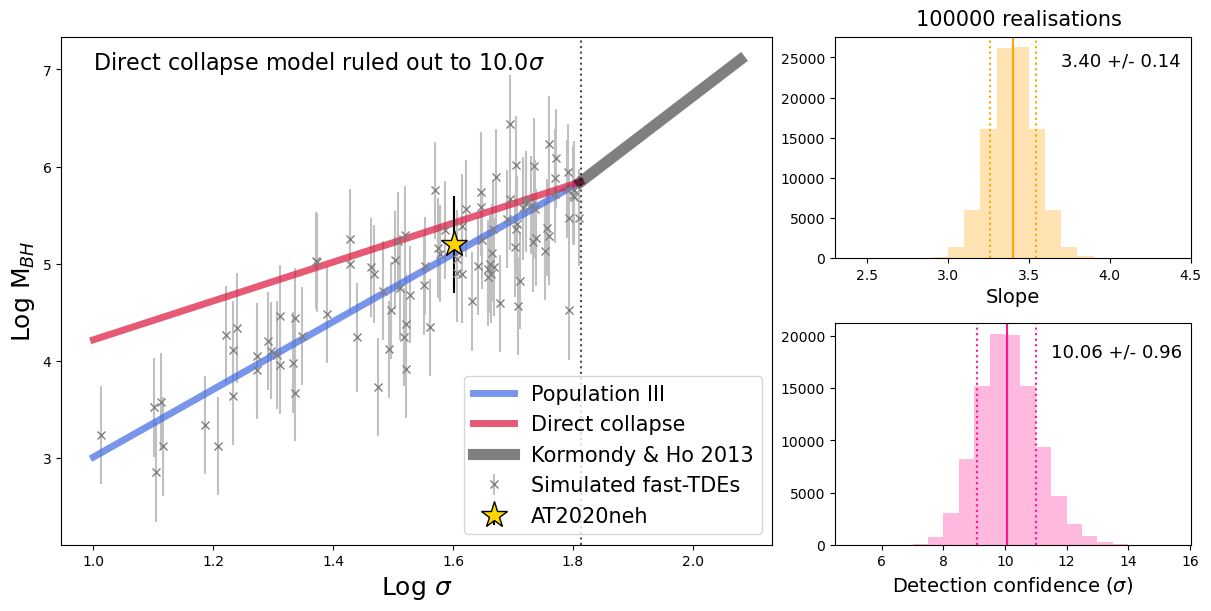

In [19]:
plot_sigma=np.array(plot_sigma)
plot_mbh=np.array(plot_mbh)
plot_mbh_err=np.array(plot_mbh_err)
plot_slope=np.array(plot_slope)

av_confidence=np.abs((3.4-2.0)/np.std(slopes))
confidence=(3.4-2.0)/np.array(slope_errs)

fig = plt.figure(layout="constrained",figsize=(12,6))

gs = GridSpec(2, 3, figure=fig)
ax0 = fig.add_subplot(gs[:, 0:-1])
ax1 = fig.add_subplot(gs[0, -1])
ax2 = fig.add_subplot(gs[-1, -1])

ax0.errorbar(plot_sigma,plot_mbh,yerr=np.abs(plot_mbh_err),color='grey',marker='x',ls='None',ecolor='silver',label='Simulated fast-TDEs')
ax0.plot(sig_x,(plot_slope*(sig_x-np.log10(65.)))+intercept,ls='-',lw=5,color='royalblue',alpha=0.7,label='Population III')
ax0.plot(sig_x,(2.0*(sig_x-np.log10(65.)))+intercept,ls='-',color='crimson',alpha=0.7,lw=5,label='Direct collapse')
ax0.plot(high_sig,np.log10((1.4*10**8)*(((10**high_sig)/200.)**4.72)),ls='-',color='k',lw=8,alpha=0.5,label='Kormondy & Ho 2013')
ax0.errorbar(np.log10(40),5.2,yerr=0.5,color='k',marker='*',ls='None',mfc='gold',ms=20,label='AT2020neh',ecolor='k',elinewidth=1.5)
ax0.axvline(np.log10(65),color='k',ls=':',alpha=0.7)
ax0.legend(loc=4,fontsize=15)
ax0.set_xlabel(r'Log $\sigma$',size=18)
ax0.set_ylabel(r'Log M$_{BH}$',size=18)
ax0.text(1.0,7.0,r'Direct collapse model ruled out to %.1f$\sigma$'%(av_confidence),size=16)

ax1.set_xlabel('Slope',size=14)
ax1.hist(slopes,color='orange',alpha=0.3,bins=np.arange(2.4,4.5,0.1))
ax1.axvline(np.median(slopes),color='orange',ls='-',alpha=1)
ax1.axvline(np.median(slopes)-np.std(slopes),color='orange',ls=':',alpha=1)
ax1.axvline(np.median(slopes)+np.std(slopes),color='orange',ls=':',alpha=1)
ax1.text(3.7,24000.1,'%.2f +/- %.2f'%(np.median(slopes),np.std(slopes)),size=13)
ax1.text(2.8,29000.1,'%i realisations'%(iterations),size=15)


ax2.set_xlabel(r'Detection confidence ($\sigma$)',size=14)
ax2.hist(confidence,color='deeppink',alpha=0.3,bins=np.arange(5,16.0,0.5))
ax2.axvline(np.median(confidence),color='deeppink',ls='-',alpha=1)
ax2.axvline(np.median(confidence)-np.std(confidence),color='deeppink',ls=':',alpha=1)
ax2.axvline(np.median(confidence)+np.std(confidence),color='deeppink',ls=':',alpha=1)
ax2.text(11.5,18000.1,'%.2f +/- %.2f'%(np.median(confidence),np.std(confidence)),size=13)
plt.savefig('Sample_sufficiency.png')
